In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import skimage
from importlib import reload
import folded_dataset
reload(folded_dataset)

<module 'folded_dataset' from '/scr/zchen/MorphEm/folded_dataset.py'>

In [2]:
root_dir = '/scr/zchen/datasets/morphem_70k_2.0/'
dataset_name = 'HPA'
df_path = f'{root_dir}{dataset_name}/enriched_meta.csv'
df = pd.read_csv(df_path)

In [3]:
dataset = folded_dataset.SingleCellDataset(csv_file=df_path,
                                           root_dir=root_dir, target_labels='train_test_split')


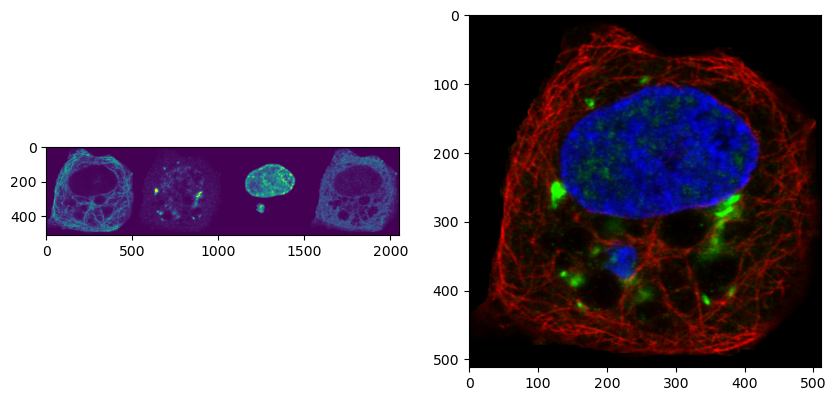

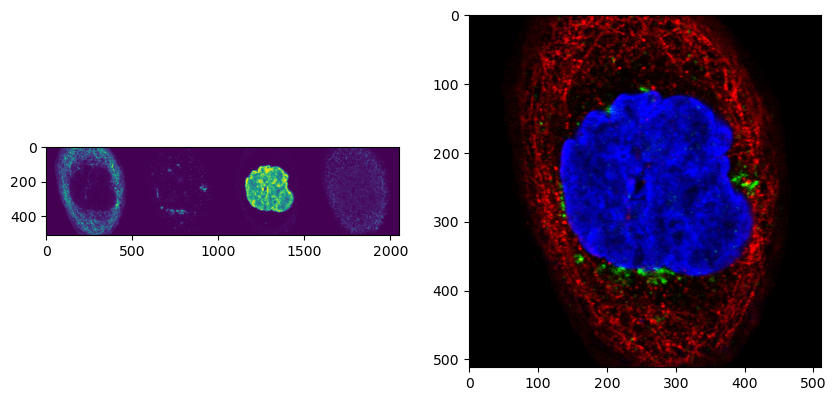

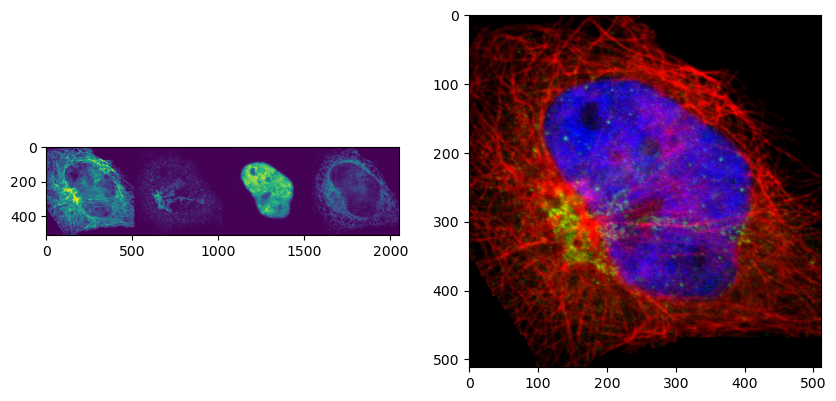

In [4]:
sample_inds = [0, 100, 200]
for ind in sample_inds:
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    axes[0].imshow(io.imread(root_dir + df.iloc[ind].file_path))
    axes[1].imshow(dataset[ind][0].numpy().transpose(1,2,0)[:,:,:3])


## ResNet Feature Extraction

In [5]:
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader
from tqdm import tqdm

In [6]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

In [7]:
weights = ResNet18_Weights.IMAGENET1K_V1
m = resnet18(weights=weights).to(device)
feature_extractor = torch.nn.Sequential(*list(m.children())[:-1]).to(device)

In [8]:
train_dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

In [9]:
preprocess = weights.transforms()
all_feat = []
for images, label in tqdm(train_dataloader, total=len(train_dataloader)):
    cloned_images = images.clone()
    batch_feat = []
    for i in range(cloned_images.shape[1]):
        # Copy each channel three times 
        channel = cloned_images[:, i, :, :]
        channel = channel.unsqueeze(1)
        expanded = channel.expand(-1, 3, -1, -1)

        expanded = preprocess(expanded).to(device)
        feat_temp = feature_extractor(expanded).cpu().detach().numpy()
        batch_feat.append(feat_temp)
    batch_feat = np.concatenate(batch_feat, axis=1)
    all_feat.append(batch_feat)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 262/262 [10:10<00:00,  2.33s/it]


In [10]:
all_feat = np.concatenate(all_feat)
all_feat = all_feat.squeeze(2).squeeze(2)
all_feat.shape

(66936, 2048)

In [11]:
feature_path = f'{root_dir}features/{dataset_name}/pretrained_resnet18_features.npy'
np.save(feature_path, all_feat)